# NCAAM Handicap Spread Coverage Network Rating

## Objective
Build network-based strength ratings using **handicap-adjusted spread coverage**.
This applies an 11-point cushion from each team's perspective to identify:
- **Cushion-Dependent Teams**: Need the handicap to cover
- **Cushion-Proof Teams**: Cover comfortably regardless of handicap

## Key Concept
- Home covers with handicap if: `spread_result_diff >= -11`
- Away covers with handicap if: `spread_result_diff <= 11`
- Games within ±11 points → both teams "cover with handicap"
- Network edge goes to team with larger handicap-adjusted margin

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# NCAAM Handicap Spread Config
CONFIG = {
    'sport': 'NCAAM',
    'handicap': 11,          # Point cushion applied to each team
    'margin_cap': 12,        # College variance slightly higher
    'recency_decay': 0.92,
    'learning_rate': 0.08,
    'iterations': 100,
    'tolerance': 0.001
}

print(f"Handicap Spread Config: {CONFIG}")

Handicap Spread Config: {'sport': 'NCAAM', 'handicap': 11, 'margin_cap': 12, 'recency_decay': 0.92, 'learning_rate': 0.08, 'iterations': 100, 'tolerance': 0.001}


## Phase 1: Data Loading

In [2]:
# Load NCAAM data
data_file = Path().resolve().parent / 'data' / 'results' / 'ncaam_season_results.xlsx'
df = pd.read_excel(data_file)

print(f"Loaded {len(df)} NCAAM games")
print(f"Date range: {df['game_date'].min().date()} to {df['game_date'].max().date()}")

# Filter to games with spread data
df_spread = df[df['spread_result_difference'].notna()].copy()
print(f"\nGames with spread data: {len(df_spread)}")

# Get all teams
all_teams = set(df_spread['home_team'].unique()) | set(df_spread['away_team'].unique())
print(f"Total teams: {len(all_teams)}")

df_spread.head()

Loaded 2280 NCAAM games
Date range: 2025-11-03 to 2026-01-05

Games with spread data: 2279
Total teams: 365


,game_date,home_team,away_team,closing_spread,home_score,away_score,spread_result_difference
0,2025-11-03,Colorado Buffaloes,Montana St Bobcats,-12.5,84,78,-6.5
1,2025-11-03,Radford Highlanders,Western Illinois Leathernecks,-16.5,80,75,-11.5
2,2025-11-03,George Mason Patriots,Wofford Terriers,-14.5,70,46,9.5
3,2025-11-03,Baylor Bears,UT Rio Grande Valley Vaqueros,-24.5,96,81,-9.5
4,2025-11-03,Wisconsin Badgers,Campbell Fighting Camels,-20.5,96,64,11.5


## Phase 2: Handicap-Adjusted Cover Determination

In [3]:
handicap = CONFIG['handicap']

# Calculate handicap-adjusted margins from each team's perspective
df_spread['home_margin_handicap'] = df_spread['spread_result_difference'] + handicap
df_spread['away_margin_handicap'] = handicap - df_spread['spread_result_difference']

# Determine if each team covers with the handicap
df_spread['home_covers_handicap'] = df_spread['spread_result_difference'] >= -handicap
df_spread['away_covers_handicap'] = df_spread['spread_result_difference'] <= handicap

# For network: cover_team is the one with larger handicap-adjusted margin
df_spread['cover_team'] = np.where(
    df_spread['home_margin_handicap'] >= df_spread['away_margin_handicap'],
    df_spread['home_team'],
    df_spread['away_team']
)
df_spread['fail_team'] = np.where(
    df_spread['home_margin_handicap'] >= df_spread['away_margin_handicap'],
    df_spread['away_team'],
    df_spread['home_team']
)
df_spread['cover_margin'] = np.maximum(
    df_spread['home_margin_handicap'],
    df_spread['away_margin_handicap']
)

# Summary statistics
print(f"Handicap Analysis ({handicap}pt cushion):")
print(f"  Games where BOTH teams cover with handicap: {(df_spread['home_covers_handicap'] & df_spread['away_covers_handicap']).sum()}")
print(f"  Games where only home covers: {(df_spread['home_covers_handicap'] & ~df_spread['away_covers_handicap']).sum()}")
print(f"  Games where only away covers: {(~df_spread['home_covers_handicap'] & df_spread['away_covers_handicap']).sum()}")
print(f"  Games where neither covers: {(~df_spread['home_covers_handicap'] & ~df_spread['away_covers_handicap']).sum()}")

df_spread[['game_date', 'home_team', 'away_team', 'spread_result_difference', 
           'home_margin_handicap', 'away_margin_handicap', 'cover_team', 'cover_margin']].head(10)

Handicap Analysis (11pt cushion):
  Games where BOTH teams cover with handicap: 1533
  Games where only home covers: 371
  Games where only away covers: 375
  Games where neither covers: 0


,game_date,home_team,away_team,spread_result_difference,home_margin_handicap,away_margin_handicap,cover_team,cover_margin
0,2025-11-03,Colorado Buffaloes,Montana St Bobcats,-6.5,4.5,17.5,Montana St Bobcats,17.5
1,2025-11-03,Radford Highlanders,Western Illinois Leathernecks,-11.5,-0.5,22.5,Western Illinois Leathernecks,22.5
2,2025-11-03,George Mason Patriots,Wofford Terriers,9.5,20.5,1.5,George Mason Patriots,20.5
3,2025-11-03,Baylor Bears,UT Rio Grande Valley Vaqueros,-9.5,1.5,20.5,UT Rio Grande Valley Vaqueros,20.5
4,2025-11-03,Wisconsin Badgers,Campbell Fighting Camels,11.5,22.5,-0.5,Wisconsin Badgers,22.5
5,2025-11-03,Charlotte 49ers,Indiana St Sycamores,11.5,22.5,-0.5,Charlotte 49ers,22.5
6,2025-11-03,Loyola (Chi) Ramblers,Cleveland St Vikings,-15.5,-4.5,26.5,Cleveland St Vikings,26.5
7,2025-11-03,UIC Flames,Detroit Mercy Titans,10.5,21.5,0.5,UIC Flames,21.5
8,2025-11-03,Kansas Jayhawks,Green Bay Phoenix,12.5,23.5,-1.5,Kansas Jayhawks,23.5
9,2025-11-03,Milwaukee Panthers,Hampton Pirates,-1.5,9.5,12.5,Hampton Pirates,12.5


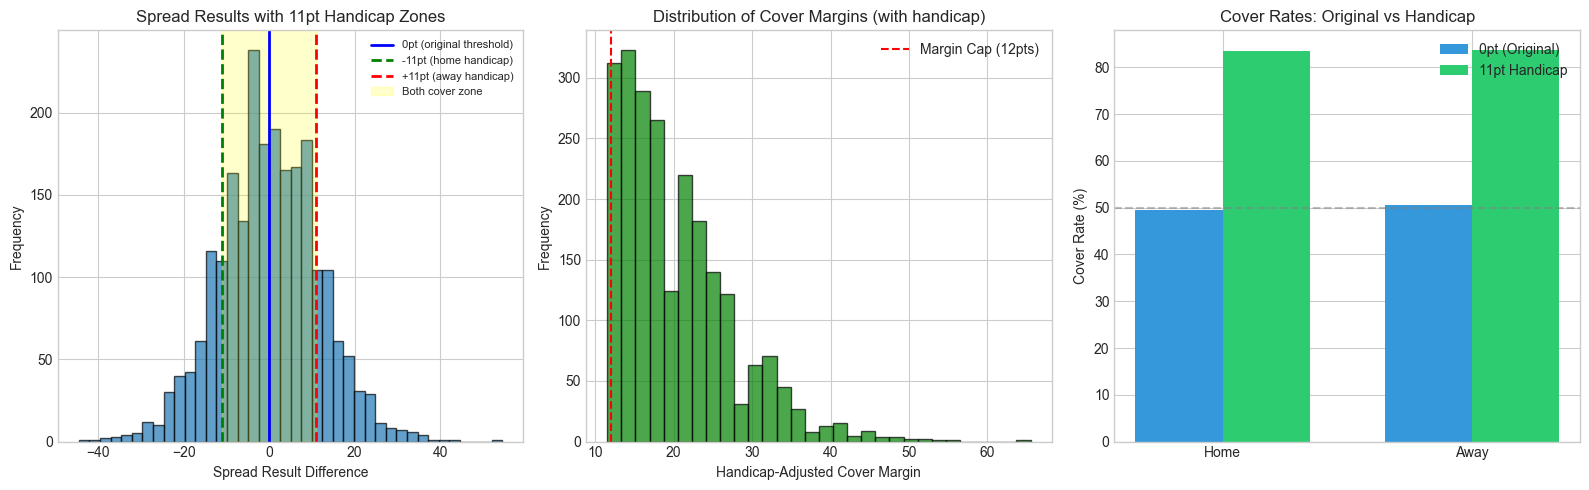


Original Cover Rates: Home 49.4%, Away 50.6%
Handicap Cover Rates: Home 83.5%, Away 83.7%


In [4]:
# Visualize handicap coverage distribution
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Original spread result distribution with handicap thresholds
ax = axes[0]
ax.hist(df_spread['spread_result_difference'], bins=40, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='blue', linestyle='-', linewidth=2, label='0pt (original threshold)')
ax.axvline(x=-handicap, color='green', linestyle='--', linewidth=2, label=f'-{handicap}pt (home handicap)')
ax.axvline(x=handicap, color='red', linestyle='--', linewidth=2, label=f'+{handicap}pt (away handicap)')
ax.axvspan(-handicap, handicap, alpha=0.2, color='yellow', label='Both cover zone')
ax.set_xlabel('Spread Result Difference')
ax.set_ylabel('Frequency')
ax.set_title(f'Spread Results with {handicap}pt Handicap Zones')
ax.legend(fontsize=8)

# Cover margin distribution (handicap-adjusted)
ax = axes[1]
ax.hist(df_spread['cover_margin'], bins=30, edgecolor='black', alpha=0.7, color='green')
ax.axvline(x=CONFIG['margin_cap'], color='r', linestyle='--', label=f"Margin Cap ({CONFIG['margin_cap']}pts)")
ax.set_xlabel('Handicap-Adjusted Cover Margin')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Cover Margins (with handicap)')
ax.legend()

# Compare: original vs handicap cover rates
ax = axes[2]
original_home_cover = (df_spread['spread_result_difference'] >= 0).mean() * 100
original_away_cover = (df_spread['spread_result_difference'] < 0).mean() * 100
handicap_home_cover = df_spread['home_covers_handicap'].mean() * 100
handicap_away_cover = df_spread['away_covers_handicap'].mean() * 100

x = np.arange(2)
width = 0.35
ax.bar(x - width/2, [original_home_cover, original_away_cover], width, label='0pt (Original)', color='#3498db')
ax.bar(x + width/2, [handicap_home_cover, handicap_away_cover], width, label=f'{handicap}pt Handicap', color='#2ecc71')
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax.set_xticks(x)
ax.set_xticklabels(['Home', 'Away'])
ax.set_ylabel('Cover Rate (%)')
ax.set_title('Cover Rates: Original vs Handicap')
ax.legend()

plt.tight_layout()
plt.show()

print(f"\nOriginal Cover Rates: Home {original_home_cover:.1f}%, Away {original_away_cover:.1f}%")
print(f"Handicap Cover Rates: Home {handicap_home_cover:.1f}%, Away {handicap_away_cover:.1f}%")

## Phase 3: Build Handicap Network & Compute Ratings

In [5]:
def build_handicap_network(games_df, recency_decay=0.92):
    """
    Build weighted directed graph from handicap-adjusted spread coverage.
    Edge: cover_team -> fail_team (based on larger handicap margin)
    """
    G = nx.DiGraph()
    
    for team in all_teams:
        G.add_node(team)
    
    games_sorted = games_df.sort_values('game_date')
    max_date = games_sorted['game_date'].max()
    
    edge_data = {}
    
    for _, game in games_sorted.iterrows():
        cover_team = game['cover_team']
        fail_team = game['fail_team']
        cover_margin = game['cover_margin']
        
        days_ago = (max_date - game['game_date']).days
        recency_weight = recency_decay ** (days_ago / 7)
        
        key = (cover_team, fail_team)
        if key not in edge_data:
            edge_data[key] = {
                'games': 0,
                'total_margin': 0,
                'weighted_margin': 0,
                'total_weight': 0
            }
        
        edge_data[key]['games'] += 1
        edge_data[key]['total_margin'] += cover_margin
        edge_data[key]['weighted_margin'] += cover_margin * recency_weight
        edge_data[key]['total_weight'] += recency_weight
    
    for (cover_team, fail_team), data in edge_data.items():
        G.add_edge(cover_team, fail_team,
                   games=data['games'],
                   avg_margin=data['total_margin'] / data['games'],
                   weighted_margin=data['weighted_margin'] / data['total_weight'])
    
    return G

G_handicap = build_handicap_network(df_spread, CONFIG['recency_decay'])

print(f"Handicap Network Summary:")
print(f"  Nodes: {G_handicap.number_of_nodes()}")
print(f"  Edges: {G_handicap.number_of_edges()}")
print(f"  Density: {nx.density(G_handicap):.3f}")

Handicap Network Summary:
  Nodes: 365
  Edges: 2273
  Density: 0.017


In [6]:
def compute_handicap_rating(games_df, max_iterations=100, tolerance=0.001, 
                            margin_cap=12, learning_rate=0.08):
    """
    Compute network-propagated handicap spread coverage ratings.
    """
    teams = set(games_df['home_team']) | set(games_df['away_team'])
    ratings = {team: 0.5 for team in teams}
    history = []
    
    for iteration in range(max_iterations):
        new_ratings = ratings.copy()
        
        for _, game in games_df.iterrows():
            cover_team = game['cover_team']
            fail_team = game['fail_team']
            cover_margin = min(game['cover_margin'], margin_cap)
            
            total = ratings[cover_team] + ratings[fail_team]
            expected = ratings[cover_team] / total if total > 0 else 0.5
            surprise = 1 - expected
            adjustment = surprise * (cover_margin / margin_cap) * learning_rate
            
            new_ratings[cover_team] += adjustment
            new_ratings[fail_team] -= adjustment
        
        min_r, max_r = min(new_ratings.values()), max(new_ratings.values())
        if max_r > min_r:
            new_ratings = {t: (r - min_r) / (max_r - min_r) for t, r in new_ratings.items()}
        
        max_change = max(abs(new_ratings[t] - ratings[t]) for t in teams)
        history.append(max_change)
        
        if max_change < tolerance:
            print(f"Converged at iteration {iteration + 1}")
            break
        
        ratings = new_ratings
    
    return ratings, history

handicap_ratings, convergence = compute_handicap_rating(
    df_spread,
    max_iterations=CONFIG['iterations'],
    tolerance=CONFIG['tolerance'],
    margin_cap=CONFIG['margin_cap'],
    learning_rate=CONFIG['learning_rate']
)

# Display top teams
handicap_df = pd.DataFrame([
    {'team': team, 'handicap_rating': rating}
    for team, rating in handicap_ratings.items()
]).sort_values('handicap_rating', ascending=False)

print("\nTop 10 Teams by Handicap Rating:")
print(handicap_df.head(10).to_string(index=False))


Top 10 Teams by Handicap Rating:
                         team  handicap_rating
        Tarleton State Texans         1.000000
          Portland St Vikings         0.915206
Stephen F. Austin Lumberjacks         0.905502
                 Mercer Bears         0.781414
        Prairie View Panthers         0.760417
         William & Mary Tribe         0.754278
                Hofstra Pride         0.750765
          Idaho State Bengals         0.735952
      Sam Houston St Bearkats         0.732701
              Denver Pioneers         0.678990


## Phase 4: Compare to Non-Handicap (0pt) Rating

In [7]:
# Compute original (0pt) spread coverage rating for comparison
df_original = df_spread.copy()
df_original['cover_team'] = np.where(
    df_original['spread_result_difference'] >= 0,
    df_original['home_team'],
    df_original['away_team']
)
df_original['fail_team'] = np.where(
    df_original['spread_result_difference'] >= 0,
    df_original['away_team'],
    df_original['home_team']
)
df_original['cover_margin'] = df_original['spread_result_difference'].abs()

original_ratings, _ = compute_handicap_rating(
    df_original,
    max_iterations=CONFIG['iterations'],
    tolerance=CONFIG['tolerance'],
    margin_cap=CONFIG['margin_cap'],
    learning_rate=CONFIG['learning_rate']
)

print("Original (0pt) spread ratings computed.")

Original (0pt) spread ratings computed.


In [8]:
# Build comparison dataframe
team_stats = []

for team in all_teams:
    home_games = df_spread[df_spread['home_team'] == team]
    away_games = df_spread[df_spread['away_team'] == team]
    total_games = len(home_games) + len(away_games)
    
    # Original cover stats
    orig_home_covers = (home_games['spread_result_difference'] >= 0).sum()
    orig_away_covers = (away_games['spread_result_difference'] < 0).sum()
    original_covers = orig_home_covers + orig_away_covers
    
    # Handicap cover stats
    hcap_home_covers = home_games['home_covers_handicap'].sum()
    hcap_away_covers = away_games['away_covers_handicap'].sum()
    handicap_covers = hcap_home_covers + hcap_away_covers
    
    team_stats.append({
        'team': team,
        'games': total_games,
        'original_covers': original_covers,
        'original_cover_pct': original_covers / total_games if total_games > 0 else 0,
        'handicap_covers': handicap_covers,
        'handicap_cover_pct': handicap_covers / total_games if total_games > 0 else 0,
        'original_rating': original_ratings.get(team, 0.5),
        'handicap_rating': handicap_ratings.get(team, 0.5)
    })

df_compare = pd.DataFrame(team_stats)

# Calculate key metrics
df_compare['handicap_delta'] = df_compare['handicap_rating'] - df_compare['original_rating']
df_compare['cover_pct_gain'] = df_compare['handicap_cover_pct'] - df_compare['original_cover_pct']

df_compare = df_compare.sort_values('handicap_delta', ascending=False)

print(f"Rating Comparison: Original (0pt) vs Handicap ({handicap}pt)")
print("="*90)
print(df_compare[['team', 'original_cover_pct', 'handicap_cover_pct', 'cover_pct_gain',
                  'original_rating', 'handicap_rating', 'handicap_delta']].head(20).to_string(index=False))

Rating Comparison: Original (0pt) vs Handicap (11pt)
                        team  original_cover_pct  handicap_cover_pct  cover_pct_gain  original_rating  handicap_rating  handicap_delta
         Portland St Vikings            0.900000            0.900000        0.000000         0.582179         0.915206        0.333027
            Coppin St Eagles            0.375000            0.687500        0.312500         0.060222         0.282858        0.222636
     Marquette Golden Eagles            0.285714            0.571429        0.285714         0.095057         0.295809        0.200752
Northern Arizona Lumberjacks            0.583333            0.916667        0.333333         0.249123         0.440309        0.191185
           Air Force Falcons            0.500000            0.750000        0.250000         0.156124         0.335676        0.179552
             Houston Cougars            0.538462            0.846154        0.307692         0.136077         0.315534        0.179457
  

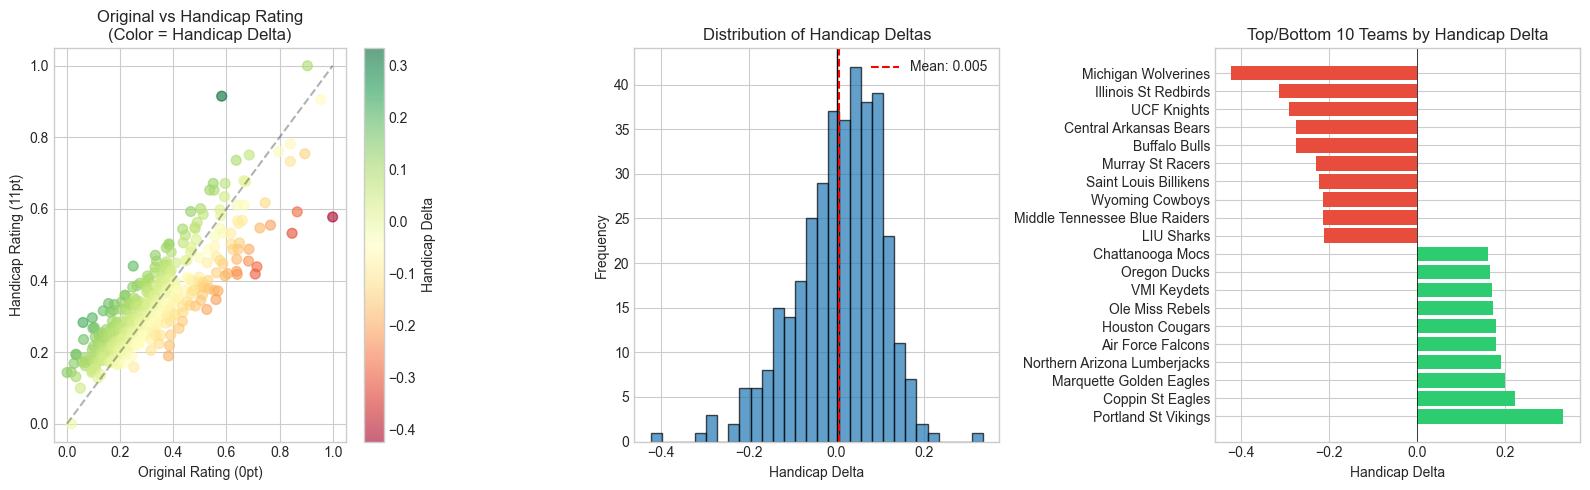

In [9]:
# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Scatter: Original vs Handicap Rating
ax = axes[0]
scatter = ax.scatter(df_compare['original_rating'], df_compare['handicap_rating'],
                     c=df_compare['handicap_delta'], cmap='RdYlGn', s=50, alpha=0.6)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Equal ratings')
ax.set_xlabel('Original Rating (0pt)')
ax.set_ylabel(f'Handicap Rating ({handicap}pt)')
ax.set_title('Original vs Handicap Rating\n(Color = Handicap Delta)')
fig.colorbar(scatter, ax=ax, label='Handicap Delta')

# Histogram of Handicap Deltas
ax = axes[1]
ax.hist(df_compare['handicap_delta'], bins=30, edgecolor='black', alpha=0.7)
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax.axvline(x=df_compare['handicap_delta'].mean(), color='red', linestyle='--', 
           label=f"Mean: {df_compare['handicap_delta'].mean():.3f}")
ax.set_xlabel('Handicap Delta')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Handicap Deltas')
ax.legend()

# Top/Bottom teams by delta
ax = axes[2]
top_bottom = pd.concat([df_compare.head(10), df_compare.tail(10)])
colors = ['#2ecc71' if d > 0 else '#e74c3c' for d in top_bottom['handicap_delta']]
ax.barh(top_bottom['team'], top_bottom['handicap_delta'], color=colors)
ax.axvline(x=0, color='black', linewidth=0.5)
ax.set_xlabel('Handicap Delta')
ax.set_title(f'Top/Bottom 10 Teams by Handicap Delta')

plt.tight_layout()
plt.show()

## Phase 5: Classify Teams (Cushion-Dependent vs Cushion-Proof)

In [10]:
# Classify teams based on handicap delta (use percentile for NCAAM due to many teams)
top_pct = df_compare['handicap_delta'].quantile(0.9)
bottom_pct = df_compare['handicap_delta'].quantile(0.1)

cushion_dependent = df_compare[df_compare['handicap_delta'] >= top_pct].sort_values('handicap_delta', ascending=False)
cushion_proof = df_compare[df_compare['handicap_delta'] <= bottom_pct].sort_values('handicap_delta')
neutral = df_compare[(df_compare['handicap_delta'] > bottom_pct) & 
                     (df_compare['handicap_delta'] < top_pct)]

print("="*80)
print(f"TEAM CLASSIFICATION ({handicap}pt Handicap Analysis)")
print("="*80)

print(f"\n\U0001F7E1 CUSHION-DEPENDENT TEAMS (Top 10% by delta, {len(cushion_dependent)} teams)")
print(f"These teams improve significantly with the {handicap}pt cushion.")
print("They may be underperforming against the spread but competitive in games.")
print("-"*80)
if len(cushion_dependent) > 0:
    print(cushion_dependent[['team', 'games', 'original_cover_pct', 'handicap_cover_pct', 
                             'original_rating', 'handicap_rating', 'handicap_delta']].head(15).to_string(index=False))

print(f"\n\U0001F7E2 CUSHION-PROOF TEAMS (Bottom 10% by delta, {len(cushion_proof)} teams)")
print(f"These teams perform WORSE relative to others with the {handicap}pt cushion.")
print("They already cover convincingly - the cushion helps their opponents more.")
print("-"*80)
if len(cushion_proof) > 0:
    print(cushion_proof[['team', 'games', 'original_cover_pct', 'handicap_cover_pct', 
                         'original_rating', 'handicap_rating', 'handicap_delta']].head(15).to_string(index=False))

print(f"\n\U00002B1C NEUTRAL TEAMS ({len(neutral)} teams)")
print(f"These teams' relative rankings don't change much with the {handicap}pt cushion.")

TEAM CLASSIFICATION (11pt Handicap Analysis)

🟡 CUSHION-DEPENDENT TEAMS (Top 10% by delta, 37 teams)
These teams improve significantly with the 11pt cushion.
They may be underperforming against the spread but competitive in games.
--------------------------------------------------------------------------------
                        team  games  original_cover_pct  handicap_cover_pct  original_rating  handicap_rating  handicap_delta
         Portland St Vikings     10            0.900000            0.900000         0.582179         0.915206        0.333027
            Coppin St Eagles     16            0.375000            0.687500         0.060222         0.282858        0.222636
     Marquette Golden Eagles     14            0.285714            0.571429         0.095057         0.295809        0.200752
Northern Arizona Lumberjacks     12            0.583333            0.916667         0.249123         0.440309        0.191185
           Air Force Falcons     12            0.500000   

## Phase 6: Predictive Analysis

In [11]:
# Split data for predictive testing
df_sorted = df_spread.sort_values('game_date')
split_idx = int(len(df_sorted) * 0.75)

train_df = df_sorted.iloc[:split_idx].copy()
test_df = df_sorted.iloc[split_idx:].copy()

print(f"Training: {len(train_df)} games")
print(f"Testing: {len(test_df)} games")

# Compute handicap ratings on training data
train_df['cover_team'] = np.where(
    train_df['home_margin_handicap'] >= train_df['away_margin_handicap'],
    train_df['home_team'],
    train_df['away_team']
)
train_df['fail_team'] = np.where(
    train_df['home_margin_handicap'] >= train_df['away_margin_handicap'],
    train_df['away_team'],
    train_df['home_team']
)
train_df['cover_margin'] = np.maximum(train_df['home_margin_handicap'], train_df['away_margin_handicap'])

train_ratings, _ = compute_handicap_rating(train_df, margin_cap=CONFIG['margin_cap'])

# Calculate test period cover rates (with handicap)
# Only include teams with at least 3 games in test period
test_cover_rates = {}
for team in all_teams:
    home_test = test_df[test_df['home_team'] == team]
    away_test = test_df[test_df['away_team'] == team]
    
    total = len(home_test) + len(away_test)
    if total >= 3:
        covers = home_test['home_covers_handicap'].sum() + away_test['away_covers_handicap'].sum()
        test_cover_rates[team] = covers / total

# Correlation
pred_df = pd.DataFrame([
    {'team': t, 'train_rating': train_ratings.get(t, 0.5), 'test_cover': test_cover_rates.get(t, np.nan)}
    for t in all_teams if t in test_cover_rates and t in train_ratings
])

corr = pred_df['train_rating'].corr(pred_df['test_cover'])
print(f"\nTeams with 3+ test games: {len(pred_df)}")
print(f"Predictive Correlation (Training Handicap Rating vs Test Cover Rate): {corr:.3f}")

Training: 1709 games
Testing: 570 games

Teams with 3+ test games: 302
Predictive Correlation (Training Handicap Rating vs Test Cover Rate): -0.086


/var/folders/jv/y3m0xwm544l00560wd0v47gh0000gn/T/ipykernel_5622/1977645840.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tier_cover = pred_df.groupby('tier')['test_cover'].mean()


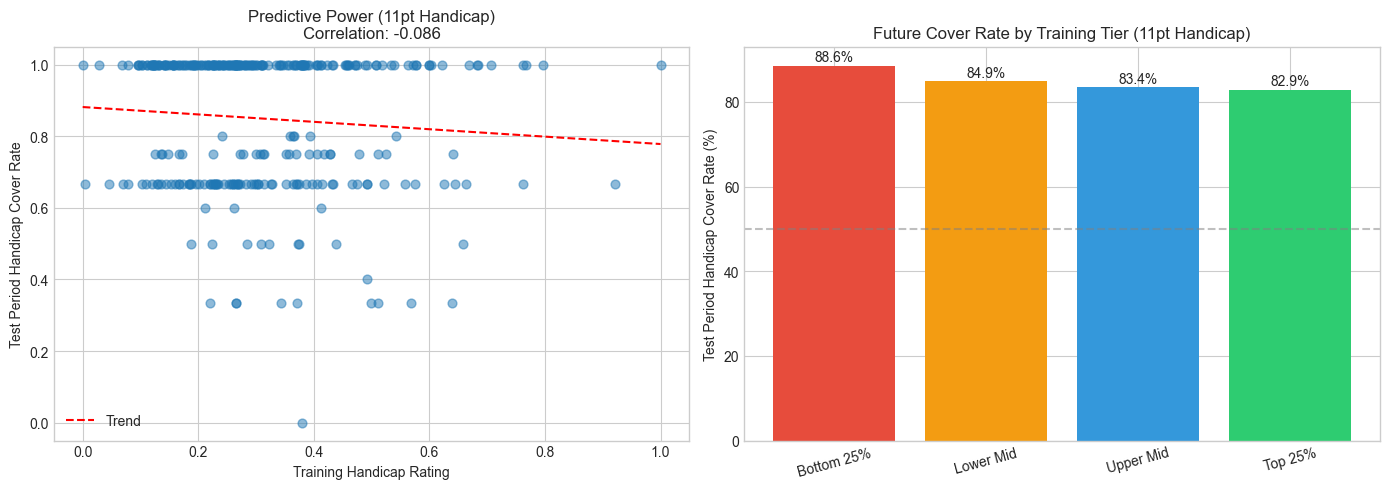

In [12]:
# Visualize predictive power
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
ax.scatter(pred_df['train_rating'], pred_df['test_cover'], alpha=0.5, s=40)
ax.set_xlabel('Training Handicap Rating')
ax.set_ylabel('Test Period Handicap Cover Rate')
ax.set_title(f'Predictive Power ({handicap}pt Handicap)\nCorrelation: {corr:.3f}')

z = np.polyfit(pred_df['train_rating'], pred_df['test_cover'], 1)
p = np.poly1d(z)
ax.plot([0, 1], [p(0), p(1)], 'r--', label=f'Trend')
ax.legend()

# Tier analysis
ax = axes[1]
pred_df['tier'] = pd.qcut(pred_df['train_rating'], q=4, labels=['Bottom 25%', 'Lower Mid', 'Upper Mid', 'Top 25%'])
tier_cover = pred_df.groupby('tier')['test_cover'].mean()

colors = ['#e74c3c', '#f39c12', '#3498db', '#2ecc71']
bars = ax.bar(tier_cover.index, tier_cover.values * 100, color=colors)
ax.axhline(y=50, color='gray', linestyle='--', alpha=0.5)
ax.set_ylabel('Test Period Handicap Cover Rate (%)')
ax.set_title(f'Future Cover Rate by Training Tier ({handicap}pt Handicap)')
ax.tick_params(axis='x', rotation=15)

for bar, val in zip(bars, tier_cover.values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, f'{val*100:.1f}%', ha='center')

plt.tight_layout()
plt.show()

## Summary

In [13]:
print("="*70)
print(f"NCAAM {handicap}PT HANDICAP SPREAD NETWORK ANALYSIS: SUMMARY")
print("="*70)

print(f"\n1. DATA")
print(f"   - Games analyzed: {len(df_spread)}")
print(f"   - Teams: {len(all_teams)}")
print(f"   - Handicap: {handicap} points")

print(f"\n2. COVER RATE CHANGES")
print(f"   - Original home cover rate: {original_home_cover:.1f}%")
print(f"   - Handicap home cover rate: {handicap_home_cover:.1f}%")
print(f"   - Games where both cover with handicap: {(df_spread['home_covers_handicap'] & df_spread['away_covers_handicap']).sum()}")

rating_corr = df_compare['original_rating'].corr(df_compare['handicap_rating'])
print(f"\n3. RATING CORRELATION")
print(f"   - Original vs Handicap rating correlation: {rating_corr:.3f}")
print(f"   - Mean handicap delta: {df_compare['handicap_delta'].mean():.4f}")
print(f"   - Std handicap delta: {df_compare['handicap_delta'].std():.4f}")

print(f"\n4. TEAM CLASSIFICATION")
print(f"   - Cushion-Dependent (top 10%): {len(cushion_dependent)} teams")
print(f"   - Cushion-Proof (bottom 10%): {len(cushion_proof)} teams")
print(f"   - Neutral: {len(neutral)} teams")

if len(cushion_dependent) > 0:
    top_dependent = cushion_dependent.iloc[0]
    print(f"   - Most cushion-dependent: {top_dependent['team']} (delta: +{top_dependent['handicap_delta']:.3f})")
if len(cushion_proof) > 0:
    top_proof = cushion_proof.iloc[0]
    print(f"   - Most cushion-proof: {top_proof['team']} (delta: {top_proof['handicap_delta']:.3f})")

print(f"\n5. PREDICTIVE POWER")
print(f"   - Training-to-Test correlation: {corr:.3f}")

NCAAM 11PT HANDICAP SPREAD NETWORK ANALYSIS: SUMMARY

1. DATA
   - Games analyzed: 2279
   - Teams: 365
   - Handicap: 11 points

2. COVER RATE CHANGES
   - Original home cover rate: 49.4%
   - Handicap home cover rate: 83.5%
   - Games where both cover with handicap: 1533

3. RATING CORRELATION
   - Original vs Handicap rating correlation: 0.850
   - Mean handicap delta: 0.0055
   - Std handicap delta: 0.0983

4. TEAM CLASSIFICATION
   - Cushion-Dependent (top 10%): 37 teams
   - Cushion-Proof (bottom 10%): 37 teams
   - Neutral: 291 teams
   - Most cushion-dependent: Portland St Vikings (delta: +0.333)
   - Most cushion-proof: Michigan Wolverines (delta: -0.422)

5. PREDICTIVE POWER
   - Training-to-Test correlation: -0.086


In [14]:
# Export results
export_df = df_compare[['team', 'games', 'original_cover_pct', 'handicap_cover_pct',
                        'original_rating', 'handicap_rating', 'handicap_delta']].copy()
export_df = export_df.sort_values('handicap_rating', ascending=False)

export_file = Path().resolve().parent / 'data' / 'results' / f'ncaam_handicap_{handicap}pt_ratings.csv'
export_df.to_csv(export_file, index=False)
print(f"Exported to: {export_file}")

export_df.head(20)

Exported to: /Users/robertbatchelor/Documents/Projects/sports-betting/backend/data/results/ncaam_handicap_11pt_ratings.csv


,team,games,original_cover_pct,handicap_cover_pct,original_rating,handicap_rating,handicap_delta
348,Tarleton State Texans,12,0.916667,0.916667,0.905021,1.000000,0.094979
193,Portland St Vikings,10,0.900000,0.900000,0.582179,0.915206,0.333027
94,Stephen F. Austin Lumberjacks,13,0.846154,1.000000,0.955185,0.905502,-0.049683
113,Mercer Bears,9,0.888889,1.000000,0.841112,0.781414,-0.059698
266,Prairie View Panthers,10,0.800000,0.900000,0.797039,0.760417,-0.036622
79,William & Mary Tribe,12,0.833333,1.000000,0.895362,0.754278,-0.141083
174,Hofstra Pride,11,0.818182,1.000000,0.685818,0.750765,0.064947
152,Idaho State Bengals,12,0.750000,0.916667,0.636874,0.735952,0.099078
46,Sam Houston St Bearkats,11,0.818182,1.000000,0.840563,0.732701,-0.107862
175,Denver Pioneers,14,0.714286,0.857143,0.665583,0.678990,0.013407
